In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('../data/velib.sqlite')
c = conn.cursor()

# First try

In [2]:
query = """
SELECT s.datetime, s.meca + s.elec AS bikes, s.park
FROM stations s
WHERE (s.stationCode = 12001 AND s.datetime BETWEEN '2021-11-01' AND '2021-11-08')
"""

In [3]:
df = pd.read_sql_query(query, conn, parse_dates="datetime", index_col="datetime")

In [4]:
import matplotlib.pyplot as plt 
import seaborn as sns

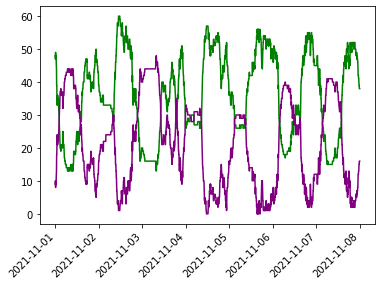

In [5]:
sns.lineplot(data=df, x='datetime', y='bikes', color='green')
sns.lineplot(data=df, x='datetime', y='park', color='purple')
plt.xlabel('')
plt.ylabel('')

for label in plt.gca().get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# Let's functionalize this
`query_stations` and `plot_station`

In [25]:
import datetime as dt
def query_stations(
    connector: sqlite3.Connection,
    station_code: int, 
    days: int = None,
    first_dt: pd.Timestamp = None,
    last_dt: pd.Timestamp = None
    ) -> pd.DataFrame:
    """
    returns the data corresponding to a station and a period of time
    requires (days & (first_dt | last_dt)) | (first_dt & last_dt)
    """
    
    if days:
        if first_dt:
            last_dt = first_dt + dt.timedelta(days=days)
        else:
            first_dt = last_dt - dt.timedelta(days=days)
    
    query = """
        SELECT s.datetime, s.meca + s.elec AS bikes, s.park
        FROM stations s
        WHERE (s.stationCode = ? 
            AND s.datetime BETWEEN ? AND ?)
    """
    params = (str(station_code), str(first_dt), str(last_dt))
    df = pd.read_sql_query(query, conn, params=params, parse_dates="datetime", index_col="datetime")

    return df

In [26]:
query_stations(conn, 12001, days=10, first_dt=pd.Timestamp('2021-12-15'))

,bikes,park
datetime,,
2021-12-15 00:00:00,29,30
2021-12-15 00:05:00,29,30
2021-12-15 00:10:00,29,30
2021-12-15 00:15:00,29,30
2021-12-15 00:20:00,29,30
...,...,...
2021-12-24 23:40:00,57,4
2021-12-24 23:45:00,57,4
2021-12-24 23:50:00,57,4


In [33]:
def plot_station(ax, df):
    
    plt.sca(ax)
    sns.lineplot(data=df, x='datetime', y='bikes', color='green')
    sns.lineplot(data=df, x='datetime', y='park', color='purple')
    plt.xlabel('')
    plt.ylabel('')
    
    ax = plt.gca()
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

<ipython-input-44-36d6306528d8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["12pm"] + [f"{i}am" for i in range(3,15,3)] + [f"{i}pm" for i in range(3,15,3)])
<ipython-input-44-36d6306528d8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["12pm"] + [f"{i}am" for i in range(3,15,3)] + [f"{i}pm" for i in range(3,15,3)])
<ipython-input-44-36d6306528d8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["12pm"] + [f"{i}am" for i in range(3,15,3)] + [f"{i}pm" for i in range(3,15,3)])
<ipython-input-44-36d6306528d8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["12pm"] + [f"{i}am" for i in range(3,15,3)] + [f"{i}pm" for i in range(3,15,3)])


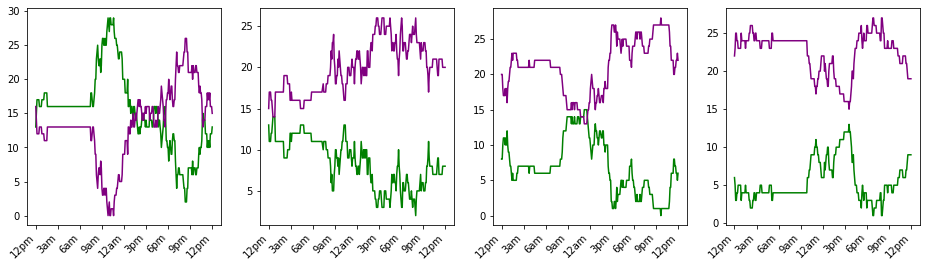

In [44]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for i, ax in enumerate(axs.flat):
    plot_station(ax, query_stations(conn, 7001, days=1, first_dt=pd.Timestamp('2021-12-16')+pd.Timedelta(days=i)))
    ax.set_xticklabels(["12 pm"] + [f"{i} am" for i in range(3,15,3)] + [f"{i} pm" for i in range(3,15,3)])

# Let's put them in two modules
`query` and `figure`

In [45]:
import os
# os.chdir('..')

In [47]:
!tree data

data
├── data-5m.csv
└── velib.sqlite

0 directories, 2 files


In [50]:
# module query in package velibapi

import sqlite3
import pandas as pd
import datetime as dt

conn = sqlite3.connect('data/velib.sqlite')
c = conn.cursor()

def query_station(
    connector: sqlite3.Connection,
    station_code: int, 
    days: int = None,
    first_dt: pd.Timestamp = None,
    last_dt: pd.Timestamp = None
    ) -> pd.DataFrame:
    """
    returns the data corresponding to a station and a period of time
    requires (days & (first_dt | last_dt)) | (first_dt & last_dt)
    """
    
    if days:
        if first_dt:
            last_dt = first_dt + dt.timedelta(days=days)
        else:
            first_dt = last_dt - dt.timedelta(days=days)
    
    query = """
        SELECT s.datetime, s.meca + s.elec AS bikes, s.park
        FROM stations s
        WHERE (s.stationCode = ? 
            AND s.datetime BETWEEN ? AND ?)
    """
    params = (str(station_code), str(first_dt), str(last_dt))
    df = pd.read_sql_query(query, conn, params=params, parse_dates="datetime", index_col="datetime")

    return df

if __name__ == '__main__':
    df = query_station(conn, 7001, days=1, first_dt=pd.Timestamp('2021-12-16'))
    print(len(df) == 289)

True


In [49]:
len(query_stations(conn, 7001, days=1, first_dt=pd.Timestamp('2021-12-16')))

289

## Après déploiement sur GCP, API accessible sur

In [59]:
import requests
API_URL = 'https://velibapi-hi7so7se7a-ew.a.run.app/day-station'
code_station = '12001'
day = '2021-12-03'

query = {
            'code_station': code_station,
            'day': day
        }

response = requests.get(API_URL, params=query).json()

In [61]:
df = pd.DataFrame(response)
df['datetime'] = pd.to_datetime(df.datetime)
df.set_index('datetime', inplace=True)

In [120]:
# module graph in front

def plot_ax_bikes_and_docks(ax, df):
    
    plt.sca(ax)
    sns.lineplot(data=df, x='datetime', y='bikes', color='green', label='available bikes')
    sns.lineplot(data=df, x='datetime', y='park', color='purple', label='available docks')
    
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()
    locs, labels = plt.xticks()
    plt.xticks(locs, [f"{i}:00" for i in range(0,24,3)] + ['0:00'], rotation=45, ha='right');
    
#     ax.set_xticklabels(["12 pm"] + [f"{i} am" for i in range(3,15,3)] + [f"{i} pm" for i in range(3,15,3)])
#     for label in ax.get_xticklabels():
#         label.set_rotation(45)
#         label.set_ha('right')

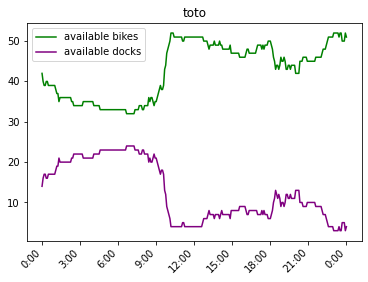

In [122]:
ax = plt.subplot()
plot_bikes_and_docks(ax, df)
plt.title(f'Station n°{code_station}, {day}')

In [139]:
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR.utf8')
dt.date(2021, 12, 15).strftime('%d/%m/%Y (%A)')

'15/12/2021 (mercredi)'